# RSI Analysis

In the orevious notebook, we identified that The RSI may have some power in predicting returns. In this notebook we will investigate this further with some statistical analysis.

## Table of Contents
1. [Introduction](#introduction)
2. [Exploring RSI](#Exploring-RSI)
0. [Next Steps](#Next-Steps)
0. [Appendix](#appendix)
<!-- 3. -->


In [62]:
import os
import sys

# add root directory to path for helper functions
if os.path.abspath("../") not in sys.path:
    sys.path.append(os.path.abspath("../"))

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera, cramervonmises, beta, anderson, kstest
import numpy as np
import warnings

from helper_functions.ingestion import get_price_data_and_rsi

warnings.filterwarnings("ignore")

## Introduction

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df = pd.read_html(url, header=0)[0]
tickers = df['Symbol'].tolist()

In [3]:
data = get_price_data_and_rsi(
    tickers=tickers,
    period=10,
    start_date="2020-01-01",
    end_date="2024-01-01",
    interval='1d',
    remove_zeros=True,
    logger_batch_size=100
    )


1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1704085200")')

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-01-01)')
2024-10-16 07:04:12.601 | INFO     | helper_functions.ingestion:get_price_data_and_rsi:45 - 100 of 503 downloaded
2024-10-16 07:04:23.697 | INFO     | helper_functions.ingestion:get_price_data_and_rsi:45 - 200 of 503 downloaded

1 Failed download:
['GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1704085200")')
2024-10-16 07:04:35.062 | INFO     | helper_functions.ingestion:get_price_data_and_rsi:45 - 300

In [15]:
data

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
MMM    2020-01-16  151.070236  151.505020  150.242477  151.346161  124.308563   
       2020-01-17  151.337799  152.299332  151.086960  151.630432  124.542038   
       2020-01-21  152.048492  152.098663  149.356186  149.991638  123.196022   
       2020-01-22  150.091980  150.978256  148.729095  148.854507  122.262062   
       2020-01-23  148.051834  149.197327  147.483276  148.612045  122.062866   
...                       ...         ...         ...         ...         ...   
ZTS    2023-12-22  195.320007  195.910004  192.740005  194.979996  193.525330   
       2023-12-26  194.880005  196.339996  194.089996  195.500000  194.041458   
       2023-12-27  195.410004  197.009995  194.740005  196.899994  195.431000   
       2023-12-28  197.619995  198.600006  196.529999  197.160004  195.689087   
       2023-12-29  196.679993  198.009995  196.250000  197.369995  195.897507   

                      Volume    Return        rsi  
Ticker Date                                        
MMM    2020-01-16  2571280.0  0.006842  54.955836  
       2020-01-17  4413360.0  0.001878  56.566023  
       2020-01-21  4027769.0 -0.010808  46.027019  
       2020-01-22  2894559.0 -0.007581  40.245933  
       2020-01-23  2820646.0 -0.001629  39.082946  
...                      ...       ...        ...  
ZTS    2023-12-22  1548400.0  0.001644  65.435833  
       2023-12-26   814600.0  0.002667  66.391233  
       2023-12-27   766400.0  0.007161  68.957994  
       2023-12-28   880100.0  0.001321  69.439624  
       2023-12-29  1007200.0  0.001065  69.859272  

[491434 rows x 8 columns]

## Exploring RSI

We will begin by examining RSI data.

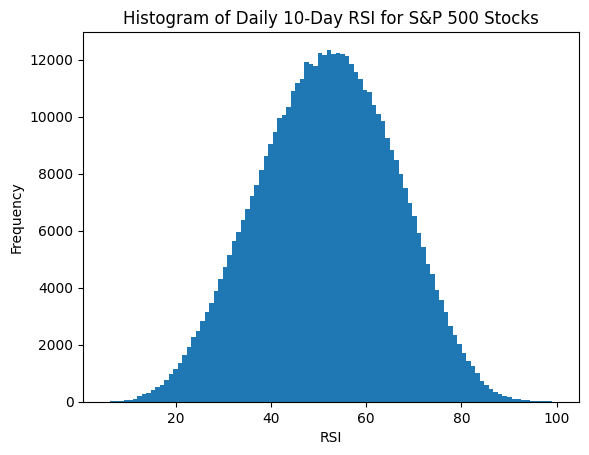

In [5]:
plt.hist(data['rsi'], bins=100)
plt.xlabel("RSI")
plt.ylabel("Frequency")
plt.title("Histogram of Daily 10-Day RSI for S&P 500 Stocks")
plt.show()

In [6]:
jb_stat, jb_pvalue = jarque_bera(data['rsi'])

print(f"Jarque-Bera test statistic: {jb_stat}")
print(f"p-value: {jb_pvalue}")

Jarque-Bera test statistic: 3710.0427735239086
p-value: 0.0


Although the histogram suggests a normal distribution, the Jarque-Bera test indicates otherwise. On further consideration, the RSI might be better modeled by a beta distribution. This is because the RSI represents the ratio of upward movement to total movement, scaled by $100$. Since total movement is always greater than or equal to upward movement, and both values are non-negative, this ratio must fall between $0$ and $1$. Consequently, the RSI is always between $0$ and $100$. If we scale the RSI by dividing it by $100$, the resulting values will lie between $0$ and $1$, aligning well with the beta distribution.

We can overlay a fitted Beta distribution on a density histogram of the data to initially assess whether the data bears some similarity to the distribution. We can also use a QQ-plot to visually verify this.



In [7]:
# first we scake and prepare the data
scaled_rsi = data['rsi'] / 100
scaled_rsi = scaled_rsi.replace(1.0, 0.9999) # beta distribution does not support values >=1
scaled_rsi = np.array(scaled_rsi).flatten()

# now fit a beta distribution
a, b, loc, scale = beta.fit(scaled_rsi)

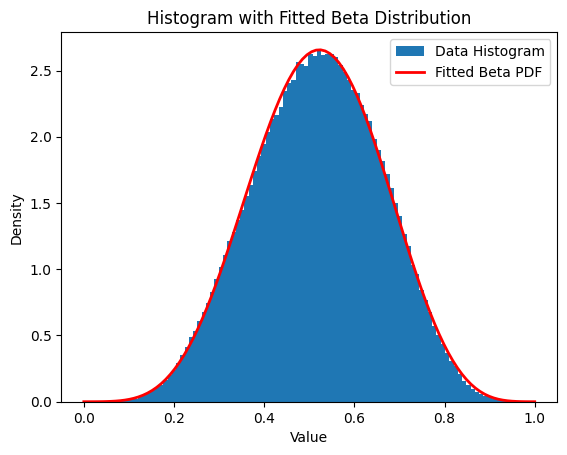

In [8]:
x = np.linspace(0, 1, 100)
pdf_fitted = beta.pdf(x, a, b, loc=loc, scale=scale)

plt.hist(scaled_rsi, bins=100, density=True, label='Data Histogram')
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Beta PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram with Fitted Beta Distribution')
plt.legend()
plt.show()

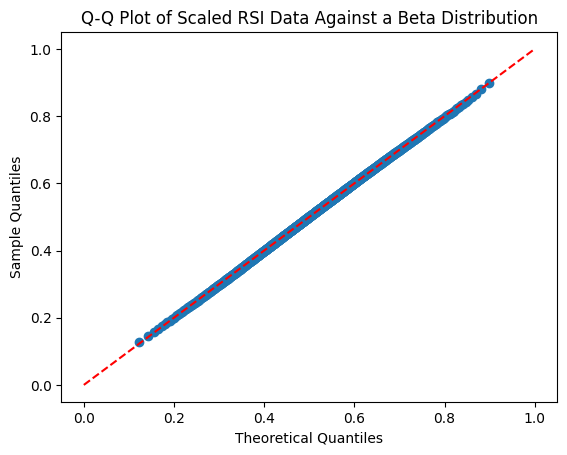

In [9]:
theoretical_quantiles = beta.ppf(np.linspace(0.001, 0.999, 1000), a, b, loc=loc, scale=scale)
sample_quantiles = np.quantile(scaled_rsi, np.linspace(0.001, 0.999, 1000))
plt.plot(theoretical_quantiles, sample_quantiles, 'o')
plt.plot([0, 1], [0, 1], 'r--')  # Reference line
plt.title('Q-Q Plot of Scaled RSI Data Against a Beta Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

While plots are useful for quickly challenging or exploring an idea, they should not be relied upon as definitive proof. Both the density plot and the QQ-plot suggest promising patterns, but this is not sufficient evidence. To confirm the hypothesis, we must conduct anither statistical test.

We can use the [Kolmogorov-Smirnov (KS) test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm) to evaluate how well a beta distribution fits the data. This test compares the empirical distribution function (EDF) of the observed data with the cumulative distribution function (CDF) of a theoretical distribution, in this case, the beta distribution. This involves the following steps:

1. We estimate the parameters (shape, scale) of the beta distribution from the data. 
2. Using the fitted beta distribution as our theoretical model, we compare it to the empirical distribution of the data.

The hypotheses are as follows:

* Null Hypothesis ($H_0$): The data follows a beta distribution.
* Alternative Hypothesis ($H_1$): The data does not follow a beta distribution.

Please refer to [Appendix A](##A.-Improving-the-KS-Test-With-Parametric-Bootsrapping) for caveats on this test and how it could be improved.

In [10]:
ks_stat, ks_pvalue = kstest(scaled_rsi, 'beta', args=(a, b, loc, scale))

In [11]:
print(f"Kolmogorov-Smirnov test statistic: {ks_stat}")
print(f"p-value: {ks_pvalue}")

Kolmogorov-Smirnov test statistic: 0.0037221509257727714
p-value: 2.4329067186298385e-06


The p-value from our KS test falls below the $0.05$ significance threshold, leading us to reject the null hypothesis and conclude that the data does not follow a beta distribution. While this result may seem surprising at first, it’s important to remember that the data is an aggregation of the RSIs from around $500$ stocks. Thus, the distribution we're observing is the outcome of multiple data-generating processes, each potentially following a beta distribution with different parameters. When considered this way, it makes sense that the data resembles a beta distribution, but also that it deviates from one.

Instead, we can perform the test individually on each stock. However, given the large number of stocks being tested, we should expect some Type I errors purely due to how the p-value is defined. 

In [103]:
# first we scake and prepare the data
GOOG_scaled_rsi = data.loc['BRO', 'rsi'] / 100
GOOG_scaled_rsi = GOOG_scaled_rsi.replace(1.0, 0.9999) # beta distribution does not support values >=1
GOOG_scaled_rsi = np.array(GOOG_scaled_rsi).flatten()

# now fit a beta distribution
a_GOOG, b_GOOG, loc_GOOG, scale_GOOG = beta.fit(GOOG_scaled_rsi)

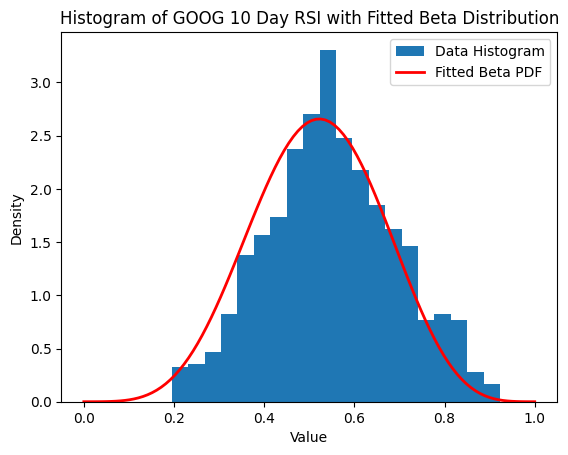

In [104]:
x = np.linspace(0, 1, 100)
GOOG_pdf_fitted = beta.pdf(x, a_GOOG, b_GOOG, loc=loc_GOOG, scale=scale_GOOG)

plt.hist(GOOG_scaled_rsi, bins=20, density=True, label='Data Histogram')
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Beta PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of GOOG 10 Day RSI with Fitted Beta Distribution')
plt.legend()
plt.show()

In [81]:
used_tickers = data.index.get_level_values(0).unique()
ks_pvalues=[]
for ticker in used_tickers:
    ticker_scaled_rsi = data.loc[ticker, 'rsi'] / 100

    ticker_scaled_rsi = ticker_scaled_rsi.replace(1.0, 0.9999) 
    ticker_scaled_rsi = np.array(ticker_scaled_rsi).flatten()

    a_ticker, b_ticker, loc_ticker, scale_ticker = beta.fit(ticker_scaled_rsi)
    _, ticker_ks_pvalue = kstest(ticker_scaled_rsi, 'beta', args=(a_ticker, b_ticker, loc_ticker, scale_ticker))
    ks_pvalues.append(ticker_ks_pvalue)

In [106]:
reject_proportion = np.mean(ks_pvalues < np.float64(0.05))
mean_ks_pvalue = np.mean(ks_pvalues)

print(f"Proportions of KS p-values that are below 0.05 (null hypothesis rejected): {reject_proportion}")
print(f"Mean KS p-value: {mean_ks_pvalue}")

Proportions of KS p-values that are below 0.05 (null hypothesis rejected): 0.01006036217303823
Mean KS p-value: 0.6449280315182422


Roughly $1\%$ of the stocks had a p-value below our significance level of $0.05$ when testing their RSI for a beta distribution. In theory, this leads us to reject the null hypothesis and conclude that the RSI is not beta-distributed in $1\%$ of cases. Some of these may represent genuine deviations from a beta distribution, while others may be Type I errors. Although we cannot definitively conclude that any individual stock's RSI follows a beta distribution, the absence of an abnormally high number of low p-values suggests that a beta distribution is generally a reasonable model for the RSI of a stock.

Note: This approach is not particularly rigorous in handling multiple p-values, but it provides sufficient confidence for the purposes of this notebook. SHould we wish to pinpoint exactly which stocks' RSIs cannot be modelled this way, we may look at conducting [Bonferonni correction](https://www.tandfonline.com/doi/abs/10.1080/01621459.1961.10482090) on the significance level. Bayesian testing could aalso offer a more robust method by allowing us to estimate the probability that each stock's RSI follows a beta distribution. These are both  methods to consider in future analyses.

## Next Steps

## Appendix

### A. Improving the KS Test With Parametric Bootsrapping 

Estimating parameters from the data adds variability to the KS test, potentially affecting the accuracy of the p-value. This happens because the KS test assumes a fully specified distribution, but here we are estimating parameters from the same data being tested.

To put it another way, the KS test is testing whether the data is drawn from the specific beta distribution defined by the fitted parameters, not just any beta distribution. If the estimated distribution does not perfectly match the true underlying distribution of the data, this discrepancy can skew the p-value.

To help mitigate this, parametric bootstrapping can be applied:

1. Repeatedly simulate samples from the fitted beta distribution.
2. For each sample, re-estimate the parameters and compute the KS test statistic for each sample.
3. Compare the observed KS test statistic to this bootstrapped distribution to get an adjusted p-value.

The critical step here is the re-estimation of the parameters in step 2. This accounts for the variability introduced by parameter estimation, effectively replicating the scenario with data that is known to follow a beta distribution. The resulting distribution of test statistics better reflects what we would expect under the null hypothesis. Comparing our observed test statistic to this empirical distribution provides a more reliable measure of significance.

However, note that this process is computationally expensive. For example, running the test with 1000 bootstrap samples took over an hour, and the results were not significantly different. While this approach is demonstrated below for reference, it is too slow for practical use in this analysis. The process could be sped up by optimising the test statistic calculation or using more efficient parameter estimation methods, but given the minimal impact on results, this would not be a good use of time for this project.



In [71]:
a, b, loc, scale = beta.fit(scaled_rsi)
ks_stat, ks_pvalue = kstest(scaled_rsi, 'beta', args=(a, b, loc, scale))

In [23]:
num_bootstrap_samples = 1000
boostrap_ks_stats = []

for i in range(num_bootstrap_samples):
    bootstrap_sample = beta.rvs(a, b, loc=loc, scale=scale, size=len(data))

    a_bootstrap, b_boostrap, loc_bootstrap, scale_bootstrap = beta.fit(bootstrap_sample)
    boostrap_ks_stat, _ = kstest(bootstrap_sample, 'beta', args=(a_bootstrap, b_boostrap, loc_bootstrap, scale_bootstrap))

    boostrap_ks_stats.append(boostrap_ks_stat)
    
    if (i+1) % 50 == 0:
        print(f"{i+1} of {num_bootstrap_samples} samples complete.")

boostrap_ks_pvalue = np.mean(boostrap_ks_stats >= ks_stat)

50 of 1000 samples complete.
100 of 1000 samples complete.
150 of 1000 samples complete.
200 of 1000 samples complete.
250 of 1000 samples complete.
300 of 1000 samples complete.
350 of 1000 samples complete.
400 of 1000 samples complete.
450 of 1000 samples complete.
500 of 1000 samples complete.
550 of 1000 samples complete.
600 of 1000 samples complete.
650 of 1000 samples complete.
700 of 1000 samples complete.
750 of 1000 samples complete.
800 of 1000 samples complete.
850 of 1000 samples complete.
900 of 1000 samples complete.
950 of 1000 samples complete.
1000 of 1000 samples complete.


In [25]:
print(f"p-value for the original KS test: {ks_pvalue}")
print(f"p-value for the boostrapped KS test: {boostrap_ks_pvalue}")

p-value for the original KS test: 2.4329067186298385e-06
p-value for the boostrapped KS test: 0.0


**Author Note**:

*Conceptually, this method is still not perfect. I remain unsure to what extent the values of the fitted parameters affect the bootstrapped distribution. This raises the question: could any set of parameters be chosen for the sampling distribution in step 1 and still produce the same bootstrapped distribution? I suspect not. Changing the parameters, especially increasing the variance, would lead to more varied data and poorer parameter estimates in the re-estimation step. This would result in a broader range of beta distributions being tested, and consequently, a wider range of test statistics in the bootstrapped distribution.*

*Thus, even if the data is genuinely beta-distributed, poor initial parameter estimation—particularly underestimating variance—could lead to an erroneously low p-value. The refitting step does not mitigate this issue. A lower variance in the initial fitted distribution causes the bootstrapped samples, and consequently the refitted distributions, to have reduced variability. Thus, the effect of parameter estimation is understated in the bootstrapped distribution of the test statistic.*

*Strictly speaking, because we are still simulating the empirical distribution of the test statistic under a specific beta distribution, the null hypothesis remains tied to that distribution. Therefore, I hesitate to call this a test for any beta distribution. What this adjustment seems to achieve is a better detection of whether the data is beta-distributed with parameters sufficiently close to the ones we estimate. The exact meaning of “sufficiently close” would depend on the parameter estimation method used, and fully working that out would require mathematics beyond the scope of this notebook—or even this project. Nonetheless, I am eager to dive deeper into this topic, perhaps in a dedicated research piece at a later date.*

